# 12.4e: Dimensional Variation Analysis

**Goal:** Analyze which dimensions vary across Qwen's 124 unique dead token vectors.

## The Question

Qwen's 2,100 dead tokens form 124 unique vectors that are all "touching" (L∞ ≤ 2ε).

This means in most dimensions they're nearly identical, with variation concentrated in a few dimensions.

**We want to know:**
1. Which dimensions vary the most?
2. How many dimensions show significant variation?
3. What's the distribution of per-dimension ranges?

This will tell us if the 124 unique vectors are basically "one vector with a few bits flipped" or something more complex.

## Parameters

In [1]:
# Input
CLUSTER_PATH = "../data/tensors/cluster_l1_distances.safetensors"

# Epsilon (bfloat16 ULP at Qwen's scale)
EPSILON = 5.9604645e-05

# Figure settings
DPI = 150

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print("Loading dead token unique vectors...\n")

data = load_file(CLUSTER_PATH)
vectors = data['vectors'].to(torch.float32)
token_ids = data['token_ids']

print(f"✓ Loaded {len(vectors)} unique vectors")
print(f"  Shape: {vectors.shape}")
print(f"  Dtype: {vectors.dtype}")

n_unique, n_dims = vectors.shape

Loading dead token unique vectors...

✓ Loaded 124 unique vectors
  Shape: torch.Size([124, 2560])
  Dtype: torch.float32


## Compute Per-Dimension Statistics

In [4]:
print("\nComputing per-dimension variation...\n")

# For each dimension, compute min/max/range across all 124 vectors
dim_min = vectors.min(dim=0)[0]  # [2560]
dim_max = vectors.max(dim=0)[0]  # [2560]
dim_range = dim_max - dim_min    # [2560]

# Normalize by epsilon
dim_range_in_ulps = dim_range / EPSILON

print(f"Per-dimension ranges (in units of ε):")
print(f"  Min range: {dim_range_in_ulps.min().item():.6f} ULPs")
print(f"  Max range: {dim_range_in_ulps.max().item():.6f} ULPs")
print(f"  Mean range: {dim_range_in_ulps.mean().item():.6f} ULPs")
print(f"  Median range: {dim_range_in_ulps.median().item():.6f} ULPs")

# Count dimensions with significant variation
n_varying = (dim_range_in_ulps > 0.1).sum().item()  # Vary by more than 0.1 ULP
n_constant = (dim_range_in_ulps < 1e-10).sum().item()  # Essentially constant

print(f"\nDimension variation:")
print(f"  Constant dimensions (range < 1e-10 ULP): {n_constant}")
print(f"  Varying dimensions (range > 0.1 ULP): {n_varying}")
print(f"  Percentage varying: {n_varying/n_dims*100:.1f}%")


Computing per-dimension variation...

Per-dimension ranges (in units of ε):
  Min range: 0.000000 ULPs
  Max range: 1.024004 ULPs
  Mean range: 0.618850 ULPs
  Median range: 0.640000 ULPs

Dimension variation:
  Constant dimensions (range < 1e-10 ULP): 379
  Varying dimensions (range > 0.1 ULP): 2181
  Percentage varying: 85.2%


## Find Top Varying Dimensions

In [5]:
# Sort dimensions by range (descending)
sorted_ranges, sorted_dims = torch.sort(dim_range_in_ulps, descending=True)

print("\nTop 20 varying dimensions:")
print(f"{'Rank':>6} {'Dimension':>10} {'Range (ULPs)':>15} {'Range (absolute)':>20}")
print("-" * 60)

for i in range(min(20, len(sorted_dims))):
    dim_idx = sorted_dims[i].item()
    range_ulps = sorted_ranges[i].item()
    range_abs = dim_range[dim_idx].item()
    print(f"{i+1:>6} {dim_idx:>10} {range_ulps:>15.6f} {range_abs:>20.6e}")

# Check if variation is concentrated in a few dimensions
top_10_fraction = sorted_ranges[:10].sum() / sorted_ranges.sum()
print(f"\nTop 10 dimensions account for {top_10_fraction*100:.1f}% of total variation")


Top 20 varying dimensions:
  Rank  Dimension    Range (ULPs)     Range (absolute)
------------------------------------------------------------
     1        969        1.024004         6.103539e-05
     2        322        1.024000         6.103516e-05
     3        668        1.024000         6.103516e-05
     4       1682        1.024000         6.103516e-05
     5       1117        1.024000         6.103516e-05
     6       1688        1.024000         6.103516e-05
     7          6        1.024000         6.103516e-05
     8       1119        1.024000         6.103516e-05
     9       1103        1.024000         6.103516e-05
    10       2544        1.024000         6.103516e-05
    11       1101        1.024000         6.103516e-05
    12       2539        1.024000         6.103516e-05
    13       1120        1.024000         6.103516e-05
    14       1124        1.024000         6.103516e-05
    15       2535        1.024000         6.103516e-05
    16         15        1.0240

## Figure 1: Per-Dimension Range Distribution

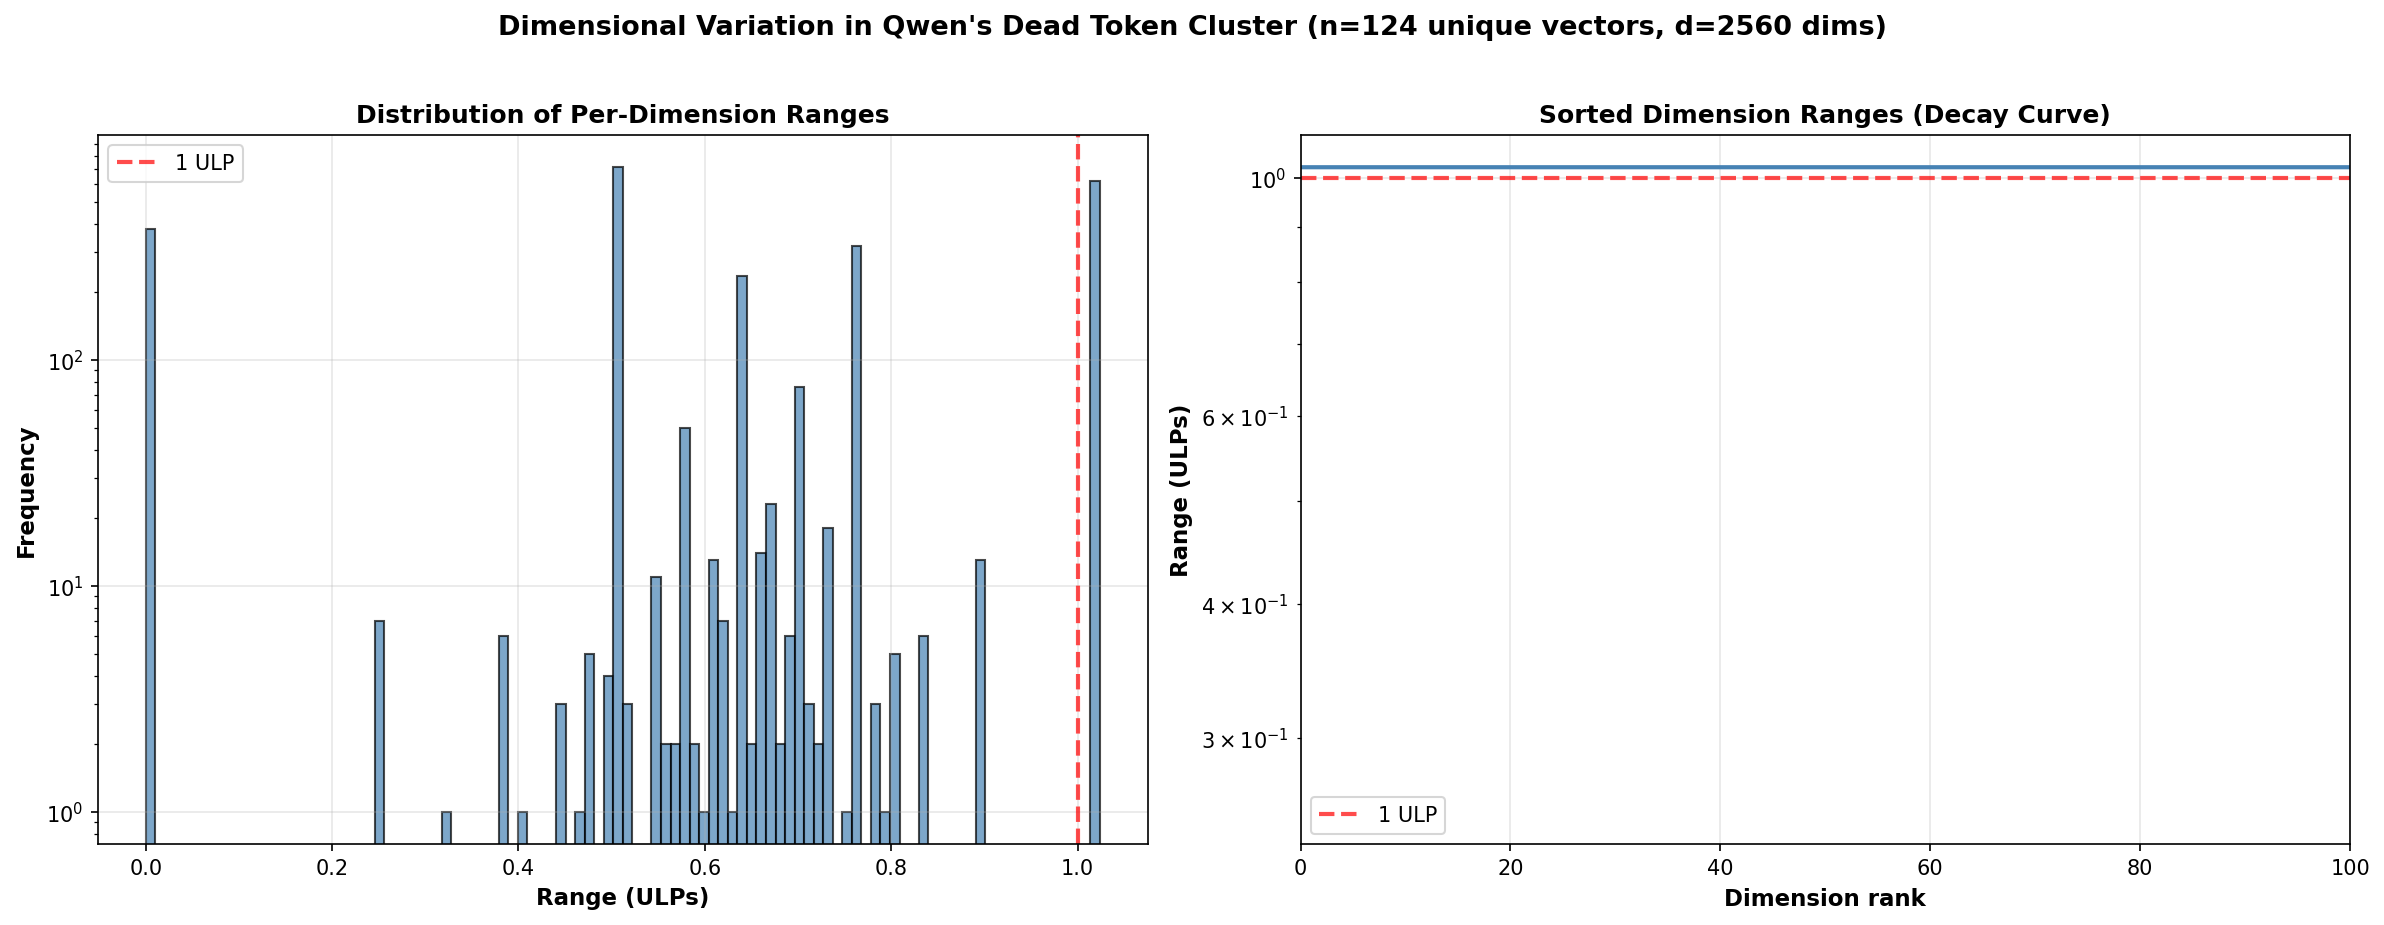

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

# Left: Histogram of ranges
ax = axes[0]
ranges_np = dim_range_in_ulps.cpu().numpy()
ax.hist(ranges_np, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='1 ULP')
ax.set_xlabel('Range (ULPs)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Per-Dimension Ranges', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right: Sorted ranges (decay curve)
ax = axes[1]
ax.plot(sorted_ranges.cpu().numpy(), color='steelblue', linewidth=2)
ax.axhline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='1 ULP')
ax.set_xlabel('Dimension rank', fontsize=11, fontweight='bold')
ax.set_ylabel('Range (ULPs)', fontsize=11, fontweight='bold')
ax.set_title('Sorted Dimension Ranges (Decay Curve)', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(0, 100)  # Focus on first 100 dimensions
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle(f'Dimensional Variation in Qwen\'s Dead Token Cluster (n={n_unique} unique vectors, d={n_dims} dims)',
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

## Figure 2: Pairwise L∞ Distance Matrix

Show which pairs of unique vectors are close (touching) vs far apart.

In [7]:
print("\nComputing pairwise L∞ distances...")

# Compute L∞ distance matrix (memory efficient with cdist)
l_inf_matrix = torch.cdist(vectors, vectors, p=float('inf'))

# Normalize by epsilon
l_inf_matrix_ulps = l_inf_matrix / EPSILON

print(f"✓ Computed {n_unique}×{n_unique} pairwise distances")
print(f"\nPairwise L∞ distances (in ULPs):")
print(f"  Min (excluding diagonal): {l_inf_matrix_ulps[l_inf_matrix_ulps > 0].min().item():.6f}")
print(f"  Max: {l_inf_matrix_ulps.max().item():.6f}")
print(f"  Mean: {l_inf_matrix_ulps.mean().item():.6f}")
print(f"  Median: {l_inf_matrix_ulps.median().item():.6f}")

# Count pairs that are "touching" (within 2ε)
touching_threshold = 2.0
n_touching = ((l_inf_matrix_ulps <= touching_threshold) & (l_inf_matrix_ulps > 0)).sum().item()
total_pairs = n_unique * (n_unique - 1)
print(f"\nTouching pairs (L∞ ≤ 2ε): {n_touching} / {total_pairs} ({n_touching/total_pairs*100:.1f}%)")


Computing pairwise L∞ distances...
✓ Computed 124×124 pairwise distances

Pairwise L∞ distances (in ULPs):
  Min (excluding diagonal): 0.000125
  Max: 1.024004
  Mean: 0.436309
  Median: 0.512000

Touching pairs (L∞ ≤ 2ε): 15252 / 15252 (100.0%)


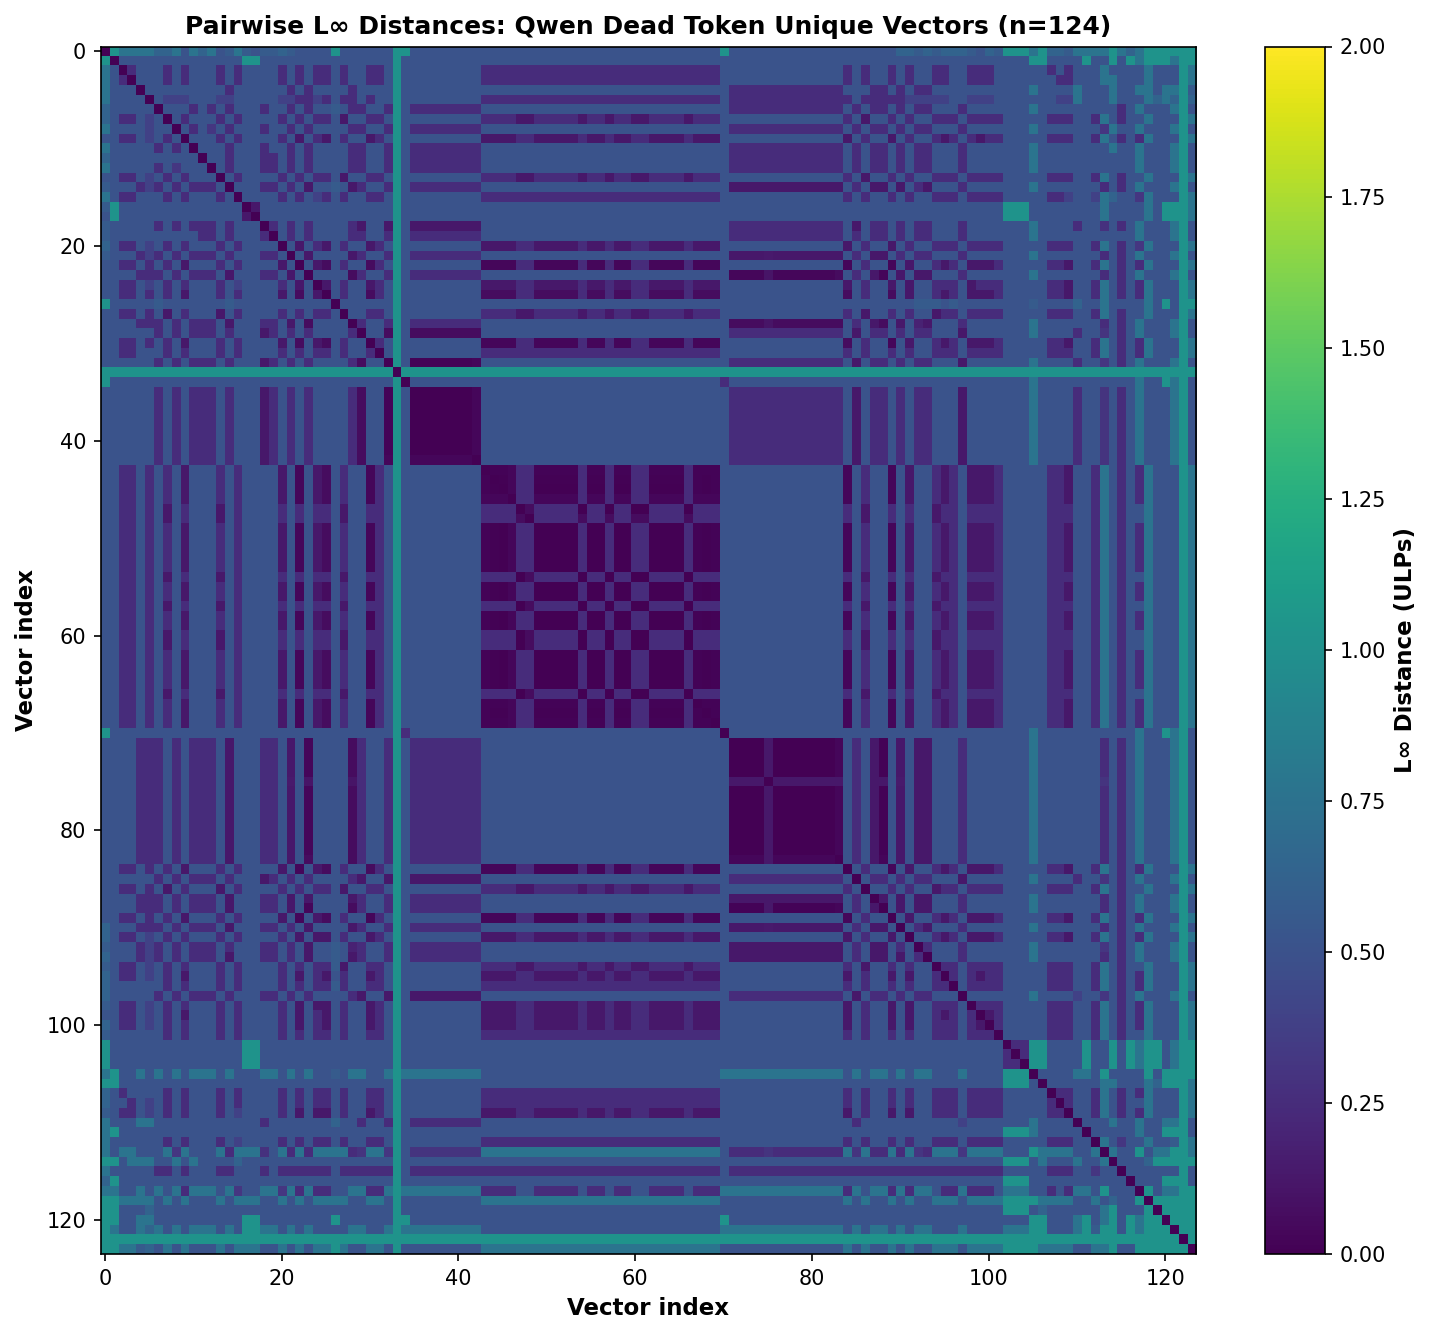


Note: Yellow/bright = far apart, Dark = touching


In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9), dpi=DPI)

im = ax.imshow(l_inf_matrix_ulps.cpu().numpy(), cmap='viridis', aspect='auto', 
               vmin=0, vmax=2.0, interpolation='nearest')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('L∞ Distance (ULPs)', fontsize=11, fontweight='bold')

ax.set_xlabel('Vector index', fontsize=11, fontweight='bold')
ax.set_ylabel('Vector index', fontsize=11, fontweight='bold')
ax.set_title(f'Pairwise L∞ Distances: Qwen Dead Token Unique Vectors (n={n_unique})',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nNote: Yellow/bright = far apart, Dark = touching")

## Summary

In [9]:
print(f"\n{'='*80}")
print(f"DIMENSIONAL VARIATION SUMMARY")
print(f"{'='*80}")
print(f"\nQwen's 124 unique dead token vectors:")
print(f"  Total dimensions: {n_dims}")
print(f"  Constant dimensions: {n_constant} ({n_constant/n_dims*100:.1f}%)")
print(f"  Varying dimensions: {n_varying} ({n_varying/n_dims*100:.1f}%)")
print(f"\nVariation concentration:")
print(f"  Max range: {sorted_ranges[0].item():.6f} ULPs (dimension {sorted_dims[0].item()})")
print(f"  Top 10 dims account for {top_10_fraction*100:.1f}% of total variation")
print(f"\nPairwise distances:")
print(f"  Max L∞: {l_inf_matrix_ulps.max().item():.6f} ULPs")
print(f"  Touching pairs: {n_touching/total_pairs*100:.1f}%")

if n_varying < 100:
    print(f"\n→ Variation is CONCENTRATED in {n_varying} dimensions (<5% of total)")
    print(f"   This suggests dead tokens are NOT 'one vector + isotropic noise'")
    print(f"   but rather differ in only a few specific dimensions.")
else:
    print(f"\n→ Variation is SPREAD across {n_varying} dimensions")
    print(f"   This suggests more complex structure.")

print(f"\n{'='*80}")


DIMENSIONAL VARIATION SUMMARY

Qwen's 124 unique dead token vectors:
  Total dimensions: 2560
  Constant dimensions: 379 (14.8%)
  Varying dimensions: 2181 (85.2%)

Variation concentration:
  Max range: 1.024004 ULPs (dimension 969)
  Top 10 dims account for 0.6% of total variation

Pairwise distances:
  Max L∞: 1.024004 ULPs
  Touching pairs: 100.0%

→ Variation is SPREAD across 2181 dimensions
   This suggests more complex structure.

